In [84]:
# Import main librairies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, date, time, timedelta
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, rand_score, confusion_matrix, classification_report, accuracy_score, v_measure_score, cluster

# For images
from IPython.display import Image

# Ignore warning parts
import warnings
warnings.filterwarnings("ignore")

In [85]:
# Import datasets
orders = pd.read_csv('olist_orders_dataset.csv', sep=',')
order_reviews = pd.read_csv('olist_order_reviews_dataset.csv', sep=',')
order_items = pd.read_csv('olist_order_items_dataset.csv', sep=',')
customers = pd.read_csv('olist_customers_dataset.csv', sep=',')

## Fonctions to create standardized data

In [86]:
# Fonction to create final customer data
def data_final():
    # Create dataframe 'orders_order_reviews' = 'oor' by merging 'orders' and 'order_reviews'
    orders_order_reviews = pd.merge(orders[['order_id',
                                            'customer_id',
                                            'order_purchase_timestamp']],
                                   order_reviews[['review_id',
                                                  'order_id',
                                                  'review_score',
                                                  'review_creation_date']])
    oor = orders_order_reviews
    
    # We keep only the most recent review for each order_id ('order_id')
    oor = oor.sort_values(by = 'review_creation_date', ascending = False)
    oor = oor.drop_duplicates(subset = ['order_id'], keep ='first')
    
    # Merge datasets 'orders_order_reviews', 'customers' and 'order_items'
    orders_customers = pd.merge(oor[['order_id', 'customer_id', 'order_purchase_timestamp',
                                     'review_id','review_score']],
                                customers[['customer_id', 'customer_unique_id']])

    orders_customers = pd.merge(orders_customers,
                                order_items[['order_id', 'order_item_id', 'product_id', 'price']])
    
    # Change dtypes 'object' to 'datetime'
    orders_customers['order_purchase_timestamp'] = pd.to_datetime(orders_customers['order_purchase_timestamp'])
    # Calculate duration between today and order_purchase_timestamp
    orders_customers['last_order'] = (datetime.now() - orders_customers['order_purchase_timestamp'])
    # Keep number of days only
    orders_customers['last_order_days'] = orders_customers['last_order'].astype(str).str[:4].astype(int)
    
    # Creating dataframe with no duplicates (1 product/1 purchage for each customer): 
    # Dropping all 'customer_unique_id" duplicates
    df_no_duplicates = orders_customers.drop_duplicates(subset = ['customer_unique_id'],
                                                        keep = False)
    
    # Creating dataframe only with duplicates (several products and several purchases)
    df_duplicates = orders_customers.loc[orders_customers['customer_unique_id'].duplicated(keep = False) == True]
    
    # Change names of features in 'df_no_duplicates'
    df_no_duplicates = df_no_duplicates.rename(columns={'customer_unique_id' : 'Customer',
                                                        'price' : 'payments_total',
                                                        'review_score' : 'review_score_mean'})
    # Create new feature in 'df_no_duplicates' : number of purchases
    df_no_duplicates['number_of_purchases'] = 1
    
    # Select the date of the most recent purchase in 'df_duplicates'
    # Sort by date and create dataframe 'df_last_order'
    df_last_order = df_duplicates.sort_values('order_purchase_timestamp',
                                              ascending = False)
    # Keep the line of the customer with the most recent date
    df_last_order = df_last_order.drop_duplicates(subset = ['customer_unique_id'],
                                                  keep = 'first')
    # Change names of features in 'df_duplicates'
    df_last_order = df_last_order.rename(columns={'customer_unique_id' : 'Customer'})
    # Select relevant features
    df_last_order = df_last_order[['Customer', 'order_purchase_timestamp', 'last_order_days', 'price']]
    
    # Calculate payments_total for each customer
    # Save index for the column "price" in dataframe 'df_duplicates'
    index_price = df_duplicates.columns.get_loc('price')
    # Create list of customer_unique_id
    list_customer_unique_id = df_last_order['Customer'].unique().tolist()
    # Create new column "payments_total" in df_last_order
    df_last_order["payments_total"] = 0
    # Save index for the column "payments_total" in dataframe df_last_order
    index_payments_total = df_last_order.columns.get_loc('payments_total')
    # Reset index of dataset df_duplicates
    df_duplicates = df_duplicates.reset_index(drop = True)
    # Reset index of dataset df
    df_last_order = df_last_order.reset_index(drop = True)
    # Loop to calculate and assign payments_total to each customer
    for customer in list_customer_unique_id:
        # Save list of indexes corresponding to the same customer in df_duplicates
        index_list = df_duplicates.loc[df_duplicates['customer_unique_id'] == customer].index
        # Save index of customer in df_last_order
        index_customer = df_last_order.loc[df_last_order['Customer'] == customer].index
        # Add prices for each customers to obtain 'payment_total'
        df_last_order.iloc[index_customer, index_payments_total] = df_duplicates.iloc[index_list, index_price].sum()
    
    # Calculate number of purchases for each customer
    # Create list of customer_unique_id
    list_customer_unique_id = df_duplicates['customer_unique_id'].unique().tolist()
    # Create new column "number_of_purchases" in df_last_order
    df_last_order["number_of_purchases"] = 0
    # Save index for the column "number_of_purchases" in dataframe df_last_order
    index_number_of_purchases = df_last_order.columns.get_loc('number_of_purchases')
    # Loop to calculate and assign number_of_purchases to each customer
    for customer in list_customer_unique_id:
        # Save index of customer in df_last_order
        index_customer = df_last_order.loc[df_last_order['Customer'] == customer].index
        # Create dataframe for each customer
        df_customer = df_duplicates.loc[df_duplicates['customer_unique_id'] == customer]
        # Add number_of_purchases for each customers
        df_last_order.iloc[index_customer, index_number_of_purchases] = len(df_customer['order_id'].unique().tolist())
    
    # Calculate review_score_mean for each customer
    # Create list of customer_unique_id
    list_customer_unique_id = df_duplicates['customer_unique_id'].unique().tolist()
    # Create new column "review_score_mean" in df_last_order
    df_last_order["review_score_mean"] = 0
    # Save index for the column "review_score_mean" in dataframe df_last_order
    index_review_score_mean = df_last_order.columns.get_loc('review_score_mean')
    # Loop to calculate and assign review_score_mean to each customer
    for customer in list_customer_unique_id:
        # Save index of customer in df_last_order
        index_customer = df_last_order.loc[df_last_order['Customer'] == customer].index
        # Create dataframe for each customer
        df_customer = df_duplicates.loc[df_duplicates['customer_unique_id'] == customer]        
        # Calculate the mean of review_scores for each customers to obtain 'review_score_mean'
        df_last_order.iloc[index_customer, index_review_score_mean] = df_customer['review_score'].mean()
    
    # Concatenate dataframes keeping only common features
    data_final = pd.concat([df_no_duplicates, df_last_order], join = "inner", ignore_index = True)
    
    # Keep only relevant features
    data_final = data_final[['Customer',
                             'number_of_purchases',
                             'payments_total',
                             'order_purchase_timestamp',
                             'last_order_days',
                             'review_score_mean']]
    
    # set feature 'Customer' as index
    data_final = data_final.set_index('Customer')
    
    # return data
    return data_final

In [87]:
# Fonction to create standardized customer data with date filter
# Using Standard_Scaler
def filter_date_and_fit(data_final, date): 
    # Filter by date
    data = data_final.loc[data_final['order_purchase_timestamp'] < date]
    data = data[['number_of_purchases',
                 'payments_total',
                 'last_order_days',
                 'review_score_mean']]
    
    # Standardize data
    X = data.values
    std_scaled = preprocessing.StandardScaler().fit(X)
    X_scaled = std_scaled.transform(X)
    
    # return data
    return X_scaled

In [88]:
# Fonction to create standardized customer final data with date filter
# Using Standard_Scaler fitted on oldest customer data
def filter_date_and_predict(data_final, date):
    # Filter by date
    data = data_final.loc[data_final['order_purchase_timestamp'] < date]
    data = data[['number_of_purchases',
                 'payments_total',
                 'last_order_days',
                 'review_score_mean']]
    
    # Standardize data
    X_final = data_final[['number_of_purchases', 'payments_total', 'last_order_days', 'review_score_mean']].values
    X = data.values
    std_scaled = preprocessing.StandardScaler().fit(X)
    X_final_scaled = std_scaled.transform(X_final)
    
    # return data
    return X_final_scaled

## Calculate Rand Indexes

In [89]:
# Create non standardized final customer data
data_final = data_final()

In [90]:
# ASSIGN CLUSTERS TO FINAL DATA BY FITTING

# Create final standardized customer data (last order : 2018-09-03)
# Standard Scaler fit on Ffinal
Ffinal_fit = filter_date_and_fit(data_final, '2018-09-04')

# Create model at Tfinal and fit model to Ffinal_fit
kmfinal_fit = KMeans(n_clusters = 5,
                     max_iter = 300,
                     n_init = 10,
                     init = 'k-means++')
kmfinal_fit.fit(Ffinal_fit)
labels_k_means_final_fit = kmfinal_fit.labels_

In [91]:
# ASSIGN CLUSTERS TO FINAL DATA BY PREDICTING FROM EARLIER DATE DATA AND CALCULATE Rand Index

# Create final date
date = datetime.strptime('2018-09-04', '%Y-%m-%d').date()
date = pd.to_datetime(date)

# Create lists
Rand_Index = []
Adjusted_Rand_Index = []
Accuracy = []
V_Measure = []
Percentage = []

# Fonction to create confusion matrix and translate labels_k_means_final_predict to labels_transform
# labels_transform corresponding to labels_k_means_final_fit
def conf_mat_transform(y_true,y_pred) :
    conf_mat = confusion_matrix(y_true,y_pred)
    
    # corresp = np.argmax(conf_mat, axis=0)
    corresp = np.argmax(conf_mat, axis=0)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

# Fonction to calculate Adjusted_rand_index (safer implementation than scikit-learn implementation)
# (Overflow encountered in long scalars with scikit-learn adjusted_rand_score)
def ari(labels_true,labels_pred): 
    '''safer implementation of ari score calculation'''
    (tn, fp), (fn, tp) = cluster.pair_confusion_matrix(labels_true, labels_pred)
    tn=int(tn)
    tp=int(tp)
    fp=int(fp)
    fn=int(fn)

    # Special cases: empty data or full agreement
    if fn == 0 and fp == 0:
        return 1.0

    return 2. * (tp * tn - fn * fp) / ((tp + fn) * (fn + tn) +
                                       (tp + fp) * (fp + tn))

# Loop start for 50 weeks : # Create final standardized customer data (last order : 2018-09-03 - x weeks)
# Standard Scaler fit on Fxweek
while len(Rand_Index) < 50:
    date = date - timedelta(days = 7)
    Fweek = filter_date_and_fit(data_final, date)

    # Create initial model at Tfinal - 1 week = T1week
    km = KMeans(n_clusters = 5,
                 max_iter = 300,
                 n_init = 10,
                 init = 'k-means++')
    km.fit(Fweek)

    # Calculate the size of Fweek compared to the size of Ffinal_fit
    percentage = len(Fweek)/len(Ffinal_fit)
    Percentage.append(percentage)

    # Create final standardized customer data (last order : 2018-09-03)
    # Standard Scaler fit on F1week
    Ffinal_predict = filter_date_and_predict(data_final, date)

    # Predict clusters at Tfinal using (Tfinal - 1 week) KMeans model
    labels_k_means_final_predict = km.predict(Ffinal_predict)

    # Calculate rand score
    RI = rand_score(labels_k_means_final_fit, labels_k_means_final_predict)
    Rand_Index.append(RI)
    
    # Calculate adjusted rand score 
    ARI = ari(labels_k_means_final_fit,labels_k_means_final_predict)
    Adjusted_Rand_Index.append(ARI)
    
    # Calculate v_measure_score
    V = v_measure_score(labels_k_means_final_fit, labels_k_means_final_predict)
    V_Measure.append(V)

    # Transform labels_k_means_final_predict to labels_transform for Accuracy_score calculation
    labels_transform = conf_mat_transform(labels_k_means_final_fit, labels_k_means_final_predict)
    
    # Calculate accuracy score
    Accuracy_score = accuracy_score(labels_k_means_final_fit, labels_transform)
    Accuracy.append(Accuracy_score)
    
    # Print classification report for each cluster
    print(classification_report(labels_k_means_final_fit, labels_transform))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2013
           1       1.00      1.00      1.00     41794
           2       1.00      1.00      1.00     31632
           3       1.00      1.00      1.00     16443
           4       1.00      1.00      1.00      2839

    accuracy                           1.00     94721
   macro avg       1.00      1.00      1.00     94721
weighted avg       1.00      1.00      1.00     94721

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2013
           1       0.99      1.00      0.99     41794
           2       1.00      0.98      0.99     31632
           3       1.00      1.00      1.00     16443
           4       1.00      1.00      1.00      2839

    accuracy                           0.99     94721
   macro avg       1.00      1.00      1.00     94721
weighted avg       0.99      0.99      0.99     94721

              precisio

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2013
           1       0.78      1.00      0.87     41794
           2       1.00      0.66      0.80     31632
           3       0.98      0.89      0.93     16443
           4       1.00      1.00      1.00      2839

    accuracy                           0.87     94721
   macro avg       0.95      0.91      0.92     94721
weighted avg       0.90      0.87      0.86     94721

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      2013
           1       0.79      0.99      0.88     41794
           2       0.99      0.64      0.78     31632
           3       0.97      0.99      0.98     16443
           4       1.00      1.00      1.00      2839

    accuracy                           0.87     94721
   macro avg       0.94      0.92      0.92     94721
weighted avg       0.90      0.87      0.87     94721

              precisio

              precision    recall  f1-score   support

           0       1.00      0.79      0.88      2013
           1       0.67      1.00      0.80     41794
           2       1.00      0.44      0.61     31632
           3       0.93      0.77      0.85     16443
           4       1.00      1.00      1.00      2839

    accuracy                           0.77     94721
   macro avg       0.92      0.80      0.83     94721
weighted avg       0.84      0.77      0.75     94721

              precision    recall  f1-score   support

           0       1.00      0.79      0.88      2013
           1       0.66      1.00      0.80     41794
           2       1.00      0.43      0.60     31632
           3       0.93      0.77      0.84     16443
           4       1.00      1.00      1.00      2839

    accuracy                           0.76     94721
   macro avg       0.92      0.80      0.82     94721
weighted avg       0.84      0.76      0.75     94721

              precisio

## Visualization

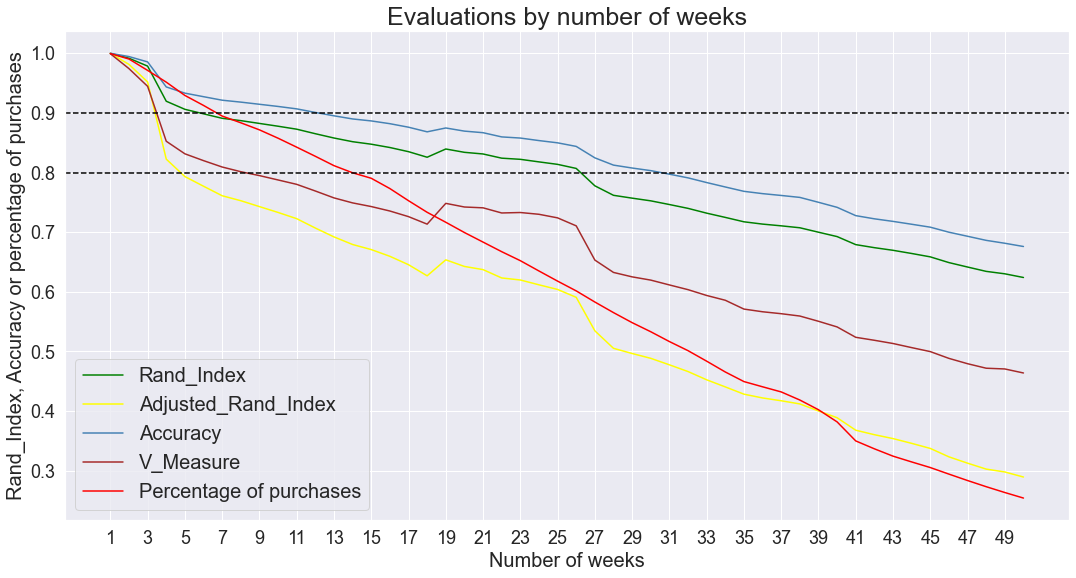

In [92]:
fig, ax = plt.subplots(figsize = (18,9))

sns.set_theme(style="darkgrid")

x = range(1, 51)
y1 = Rand_Index
y2 = Adjusted_Rand_Index
y3 = Accuracy
y4 = V_Measure
y5 = Percentage

# Plot the different metrics
ax.plot(x, y1, color = 'green', label = 'Rand_Index')
ax.plot(x, y2, color = 'yellow', label = 'Adjusted_Rand_Index')
ax.plot(x, y3, color = 'steelblue', label = 'Accuracy')
ax.plot(x, y4, color = 'brown', label = 'V_Measure')
ax.plot(x, y5, color = 'red', label = 'Percentage of purchases')
plt.axhline(0.9, color = 'black', linestyle = 'dashed')
plt.axhline(0.8, color = 'black', linestyle = 'dashed')

plt.yticks(size = 18)
plt.xticks(np.arange(min(range(1, 51)), max(range(1, 51)), 2.0), size = 18)

plt.xlabel("Number of weeks", size = 20)
plt.ylabel("Rand_Index, Accuracy or percentage of purchases", size = 20)

plt.title('Evaluations by number of weeks', size = 25)

leg = ax.legend(fontsize = 20)

plt.show()

In [93]:
# Create dataframe with results
dict_results = {'weeks': range(1,51),
                'Rand_Index': Rand_Index,
                'Adjusted_Rand_Index': Adjusted_Rand_Index,
                'Accuracy': Accuracy,
                "V_Measure": V_Measure,
                'Percentage of purchases': Percentage}
df_results = pd.DataFrame(dict_results)
df_results

,weeks,Rand_Index,Adjusted_Rand_Index,Accuracy,V_Measure,Percentage of purchases
0,1,0.999891,0.999756,0.999905,0.999218,0.999462
1,2,0.991620,0.981285,0.994394,0.974158,0.990287
2,3,0.978412,0.951872,0.985473,0.944495,0.971231
3,4,0.919550,0.822455,0.943518,0.852436,0.951542
4,5,0.905990,0.793222,0.933109,0.831389,0.929255
5,6,0.898442,0.777052,0.927154,0.819955,0.912511
6,7,0.890929,0.761081,0.921264,0.809256,0.894691
7,8,0.887022,0.752765,0.918054,0.801387,0.883405
8,9,0.882321,0.742895,0.914433,0.794863,0.871549
9,10,0.877640,0.733099,0.910801,0.787557,0.857561


## Conclusion
- Clustering could be updated every 12 weeks (Considering Accuracy < 0.9)